In [1]:
!pip install scikit-tda[all]
!pip install kmapper

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 751.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.3/841.3 kB 17.4 MB/s eta 0:00:00
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18102 sha256=760b3729f90e2f5cbd5019bef425e3b741a04014b3aad0d64645934025200c5b
  Stored in directory: /root/.cache/pip/wheels/1f/cc/2d/de23a8b9ae586817b0b44de4a4b1a08f23473e248a644b312f
Successfully built hopcroftkarp


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

# Load MNIST data
def get_data_loader(batch_size=128):
    transform = transforms.Compose([transforms.ToTensor()])
    dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

data_loader = get_data_loader()

100%|██████████| 9.91M/9.91M [00:00<00:00, 42.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 2.13MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 16.8MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.31MB/s]


In [3]:
import random

def get_digit_subset(dataloader, digit=0, num_samples=1000):
    digit_images = dataloader.dataset.data[dataloader.dataset.targets == digit]
    return digit_images[:num_samples].view(num_samples, -1)

def sample_digit_subset(dataloader, digit=0, num_samples=1000):
    digit_images = dataloader.dataset.data[dataloader.dataset.targets == digit]
    random_indices = random.sample(range(len(digit_images)), num_samples)
    return digit_images[random_indices].view(num_samples, -1)

/usr/local/lib/python3.11/dist-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


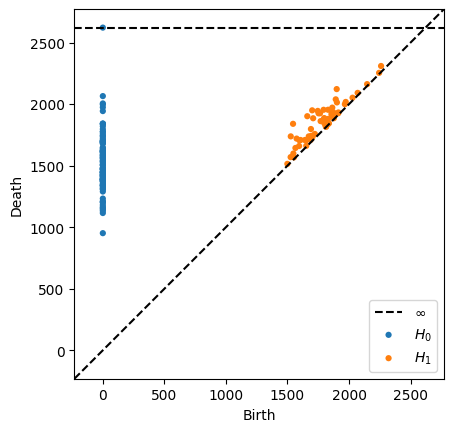

/usr/local/lib/python3.11/dist-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


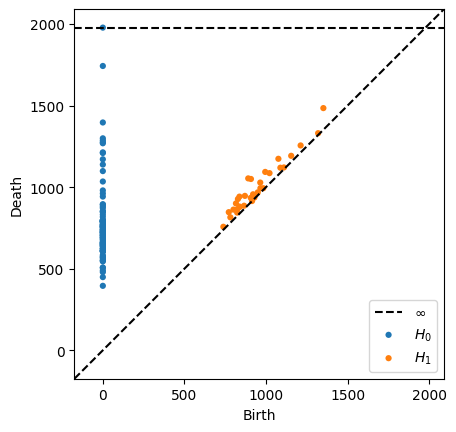

/usr/local/lib/python3.11/dist-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


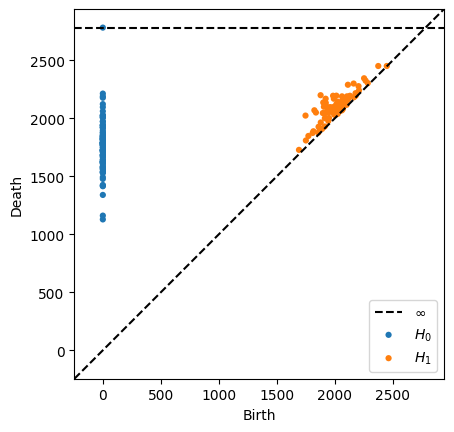

/usr/local/lib/python3.11/dist-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


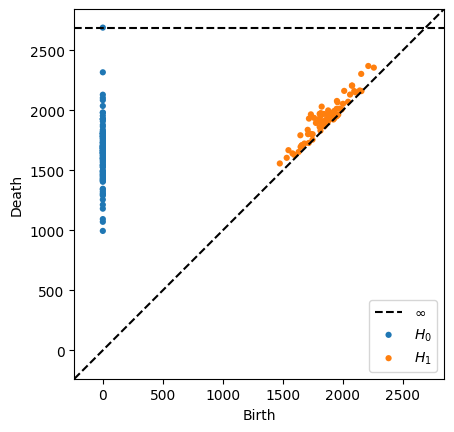

/usr/local/lib/python3.11/dist-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


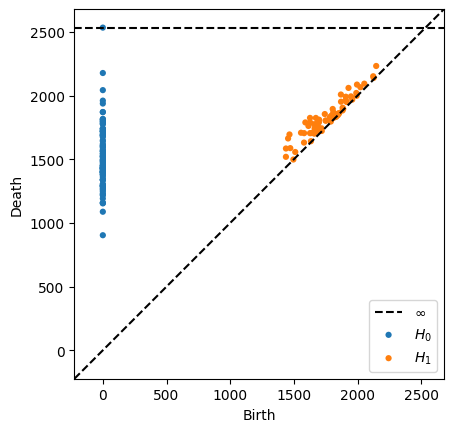

/usr/local/lib/python3.11/dist-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


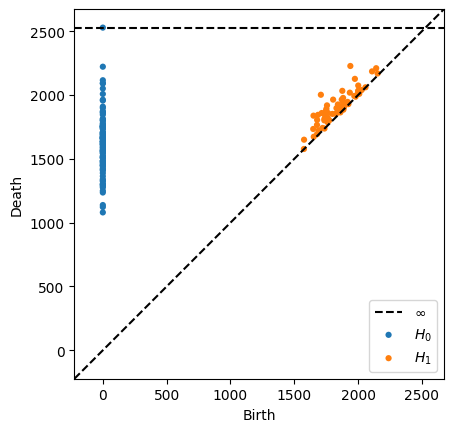

/usr/local/lib/python3.11/dist-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


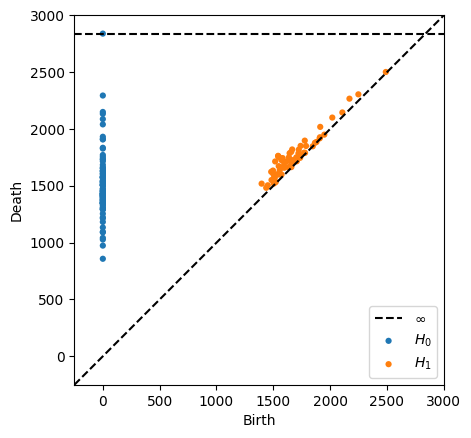

/usr/local/lib/python3.11/dist-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


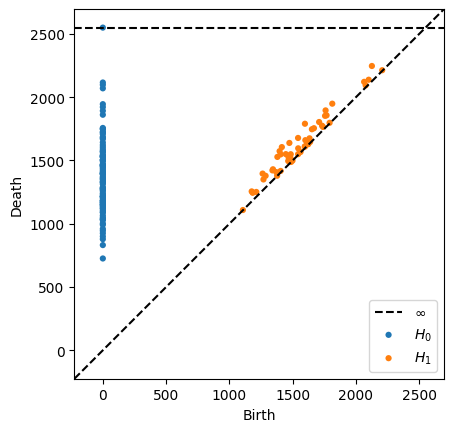

/usr/local/lib/python3.11/dist-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


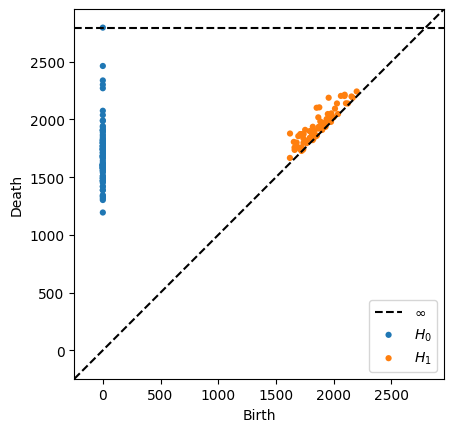

/usr/local/lib/python3.11/dist-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


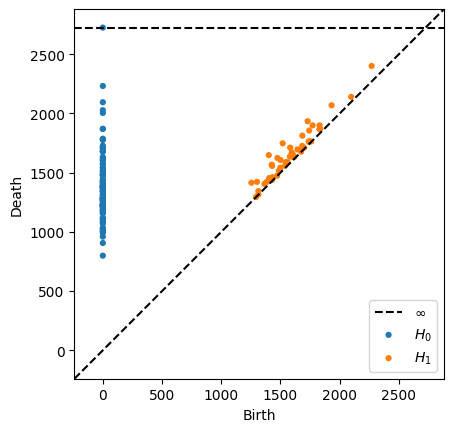

In [5]:
from ripser import ripser
from persim import plot_diagrams

for i in range(10):
    points = sample_digit_subset(data_loader, i, num_samples=100)
    diagrams = ripser(points, maxdim=1)['dgms']
    plot_diagrams(diagrams, show=True)

Individually samples tend to be 1 major connected component with no other structure

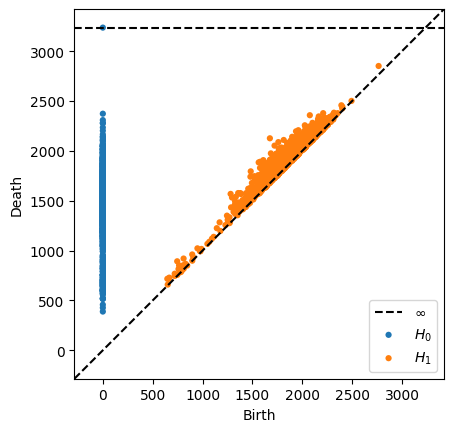

In [6]:
points = [sample_digit_subset(data_loader, i, num_samples=100) for i in range(10)]
points = torch.cat(points)

diagrams = ripser(points, maxdim=1)['dgms']
plot_diagrams(diagrams, show=True)

In [37]:
points = []
labels = []

for i in range(10):
    digit_points = sample_digit_subset(data_loader, i, num_samples=100)
    points.append(digit_points)
    labels += [i] * 100  # add 100 labels for digit i

points = torch.cat(points).numpy() / 255.0  # Normalize
labels = np.array(labels)


In [55]:
import kmapper as km
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import umap

points_reduced = PCA(n_components=50).fit_transform(points)

mapper = km.KeplerMapper(verbose=1)

graph = mapper.map(
    X=points_reduced,
    lens = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2).fit_transform(points),
    cover=km.Cover(n_cubes=8, perc_overlap=0.6),
    clusterer=DBSCAN(eps=5.0, min_samples=2)
)

KeplerMapper(verbose=1)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Mapping on data shaped (1000, 50) using lens shaped (1000, 2)

Creating 64 hypercubes.

Created 1267 edges and 371 nodes in 0:00:00.249951.


In [56]:
import base64
from io import BytesIO
from PIL import Image

def image_to_base64(img_array):
    """Convert a 28x28 image array to base64 PNG."""
    img = Image.fromarray((img_array * 255).astype(np.uint8))  # scale to 0–255
    img = img.resize((28, 28))
    buffer = BytesIO()
    img.save(buffer, format="PNG")
    return base64.b64encode(buffer.getvalue()).decode("utf-8")

image_htmls = []

for idx in range(len(points)):
    img_array = points[idx].reshape(28, 28)  # Assumes normalized to [0,1]
    img_b64 = image_to_base64(img_array)
    label = labels[idx]
    html = f'<div><img src="data:image/png;base64,{img_b64}" /><br>Label: {label}</div>'
    image_htmls.append(html)

image_htmls = np.array(image_htmls)

from google.colab import files
mapper.visualize(
    graph,
    path_html="mnist_mapper.html",
    color_values=labels,
    color_function_name=["Digit Label"],
    custom_tooltips=image_htmls,
    title="MNIST Mapper with Label Tooltips"
)
files.download('mnist_mapper.html')


Wrote visualization to: mnist_mapper.html


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
import networkx as nx

# Initialize NetworkX graph
G = nx.Graph()

# Add nodes
G.add_nodes_from(graph['nodes'].keys())

# Convert 'links' dict into list of edge tuples
edges = []
for src, targets in graph['links'].items():
    for tgt in targets:
        edges.append((src, tgt))

G.add_edges_from(edges)

# Get connected components
components = list(nx.connected_components(G))
componentLabels = []

# Analyze each connected component
for i, component in enumerate(components):
    all_indices = []
    for node_id in component:
        all_indices.extend(graph['nodes'][node_id])

    node_labels = labels[all_indices]
    unique, counts = np.unique(node_labels, return_counts=True)
    componentLabels.append(unique.tolist())

    print(f"Component {i} ({len(component)} nodes):")
    for label, count in zip(unique, counts):
        print(f"  Digit {label}: {count} samples")
    print()


Component 0 (168 nodes):
  Digit 0: 359 samples
  Digit 1: 398 samples
  Digit 2: 359 samples
  Digit 3: 384 samples
  Digit 4: 344 samples
  Digit 5: 379 samples
  Digit 6: 390 samples
  Digit 7: 348 samples
  Digit 8: 382 samples
  Digit 9: 372 samples



In [34]:
def get_component_images(component, label_filter=None):
    all_indices = []
    for node_id in component:
        all_indices.extend(graph["nodes"][node_id])

    if label_filter is not None:
        all_indices = [i for i in all_indices if labels[i] == label_filter]

    return points[all_indices], labels[all_indices]

def plot_digit_images(images, title="", max_images=25):
    plt.figure(figsize=(10, 4))
    for i in range(min(len(images), max_images)):
        plt.subplot(2, int(max_images/2), i+1)
        plt.imshow(images[i].reshape(28, 28), cmap="gray")
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


ValueError: num must be an integer with 1 <= num <= 24, not 25

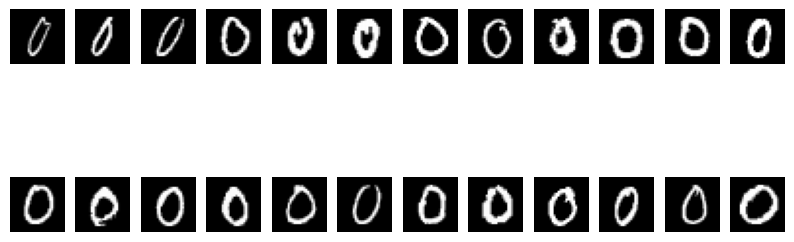

In [35]:
for idx,i in enumerate(componentLabels):
    if len(i) > 1:
        print(i)

    componentImages, imageLabels = get_component_images(components[idx], label_filter=i[0])
    plot_digit_images(componentImages, title=f"Component {idx} — Digit {i[0]}")

In [ ]:
from google.colab import _message

# Get notebook JSON data
nb = _message.blocking_request('get_ipynb')['ipynb']

# Extract and print code from all cells
for i, cell in enumerate(nb['cells']):
    if cell['cell_type'] == 'code':
        print(f"### CELL {i} ###")
        print(''.join(cell['source']))
        print("\n--- CELL SEPARATOR ---\n")

### CELL 0 ###
!pip install scikit-tda[all]
!pip install kmapper

--- CELL SEPARATOR ---

### CELL 1 ###
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

# Load MNIST data
def get_data_loader(batch_size=128):
    transform = transforms.Compose([transforms.ToTensor()])
    dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

data_loader = get_data_loader()

--- CELL SEPARATOR ---

### CELL 2 ###
import random

def get_digit_subset(dataloader, digit=0, num_samples=1000):
    digit_images = dataloader.dataset.data[dataloader.dataset.targets == digit]
    return digit_images[:num_samples].view(num_samples, -1)

def sample_digit_subset(dataloader, digit=0, num_samples=1000):
    digit_images = dataloader.dataset.data[dataloa